<a href="https://colab.research.google.com/github/FarizieFar/Machine-Learning/blob/main/Jobsheet10_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Dripping with symbolism and filled with marvelous cinematography, Extase is so much more than the erotic drama we've all come to expect. This is almost a silent film, with what dialogue there is in German, and highly simplified German at that. Perhaps the filmmakers intended the film to reach the widest possible European audience, as anyone with even a little high school level Deutsch can easily dispense with the subtitles. The story is of little importance anyway, with the film succeeding on a cinematic level, not a narrative one. Symbols of fecundity and the power of nature overwhelm the human characters--there are even scenes where flowers obscure the face of supposed star Hedy Lamarr--and there are moments here that will remind viewers of the works of Dreyer, Vertov, and Riefenstahl. If the film has any message to convey, I think it's a political one: bourgeois man is timid and impotent; working class man is a happy, productive creature; and woman is the creator, destine

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  17,   1, ...,   0,   0,   0],
       [527, 382,  11, ...,   0,   0,   0],
       [ 10, 321, 158, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Dripping with symbolism and filled with marvelous cinematography, Extase is so much more than the erotic drama we've all come to expect. This is almost a silent film, with what dialogue there is in German, and highly simplified German at that. Perhaps the filmmakers intended the film to reach the widest possible European audience, as anyone with even a little high school level Deutsch can easily dispense with the subtitles. The story is of little importance anyway, with the film succeeding on a cinematic level, not a narrative one. Symbols of fecundity and the power of nature overwhelm the human characters--there are even scenes where flowers obscure the face of supposed star Hedy Lamarr--and there are moments here that will remind viewers of the works of Dreyer, Vertov, and Riefenstahl. If the film has any message to convey, I think it's a political one: bourgeois man is timid and impotent; working class man is a happy, productive creature; and woman is the creator, desti

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.01037288]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 310ms/step
[0.01037288]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

Epoch 1/10
391/391 [==============================] - 650s 2s/step - loss: 0.6399 - accuracy: 0.5678 - val_loss: 0.4833 - val_accuracy: 0.7734
Epoch 2/10
391/391 [==============================] - 639s 2s/step - loss: 0.3944 - accuracy: 0.8173 - val_loss: 0.3497 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 638s 2s/step - loss: 0.3349 - accuracy: 0.8538 - val_loss: 0.3370 - val_accuracy: 0.8406
Epoch 4/10
391/391 [==============================] - 601s 2s/step - loss: 0.3196 - accuracy: 0.8610 - val_loss: 0.3403 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 599s 2s/step - loss: 0.3128 - accuracy: 0.8637 - val_loss: 0.3260 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 608s 2s/step - loss: 0.3131 - accuracy: 0.8624 - val_loss: 0.3227 - val_accuracy: 0.8495
Epoch 7/10
391/391 [==============================] - 596s 2s/step - loss: 0.3070 - accuracy: 0.8677 - val_loss: 0.3179 - val_accuracy: 0.8568

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 167s 428ms/step - loss: 0.3223 - accuracy: 0.8515
Test Loss: 0.32228884100914
Test Accuracy: 0.8514800071716309


(0.0, 0.6684149205684662)

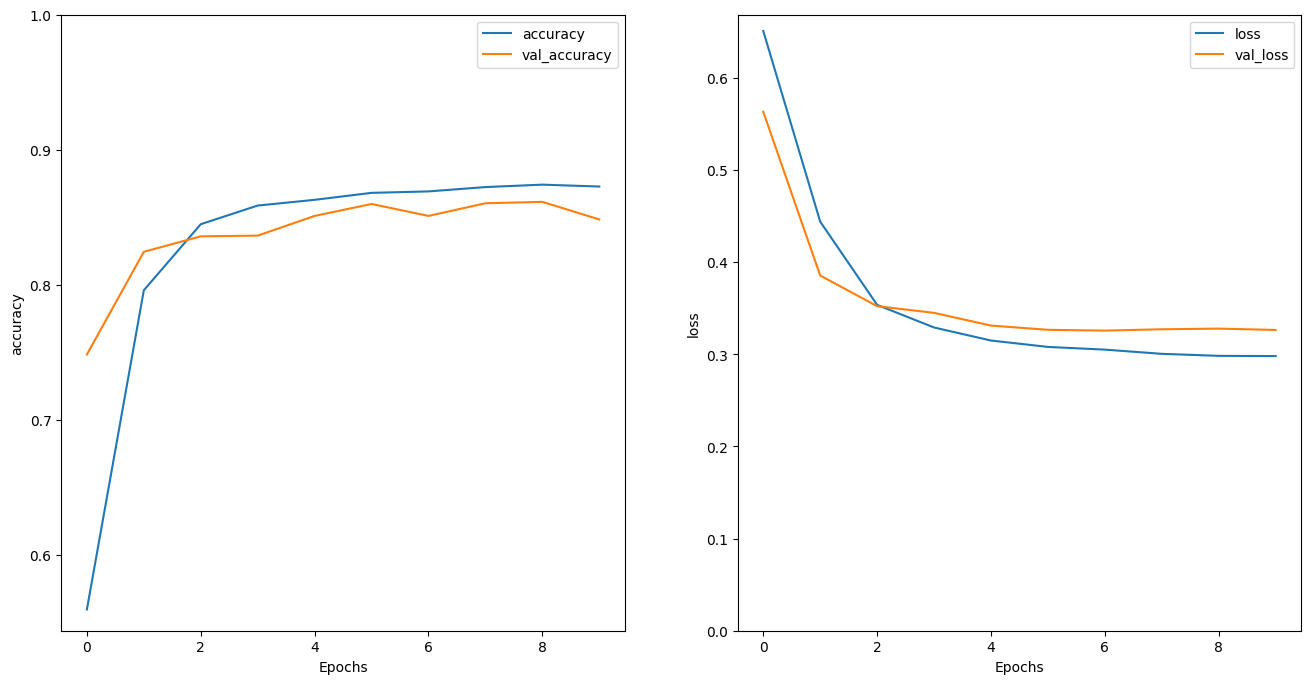

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


**Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
encoder,
      tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1495s 4s/step - loss: 0.6427 - accuracy: 0.5606 - val_loss: 0.4721 - val_accuracy: 0.7958
Epoch 2/10
391/391 [==============================] - 1370s 4s/step - loss: 0.3985 - accuracy: 0.8248 - val_loss: 0.3837 - val_accuracy: 0.7979
Epoch 3/10
391/391 [==============================] - 1342s 3s/step - loss: 0.3413 - accuracy: 0.8530 - val_loss: 0.3377 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 1343s 3s/step - loss: 0.3224 - accuracy: 0.8629 - val_loss: 0.3330 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 1312s 3s/step - loss: 0.3124 - accuracy: 0.8671 - val_loss: 0.3218 - val_accuracy: 0.8536
Epoch 6/10
  5/391 [..............................] - ETA: 23:19 - loss: 0.3067 - accuracy: 0.8750